Ho separato le immagini perché se no serve una mappa per navigare quel file


Qui non commento tutto, Chiara io credo in te ce la puoi fare

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from PIL import Image
# Load the JPEG image
import os
from skimage.filters.rank import mean as mean_filter
import csv
import pandas as pd

B = Image.open('sangue_rana/B.jpg')
B = np.array(B)
print(B.shape)

(1022, 1022, 3)


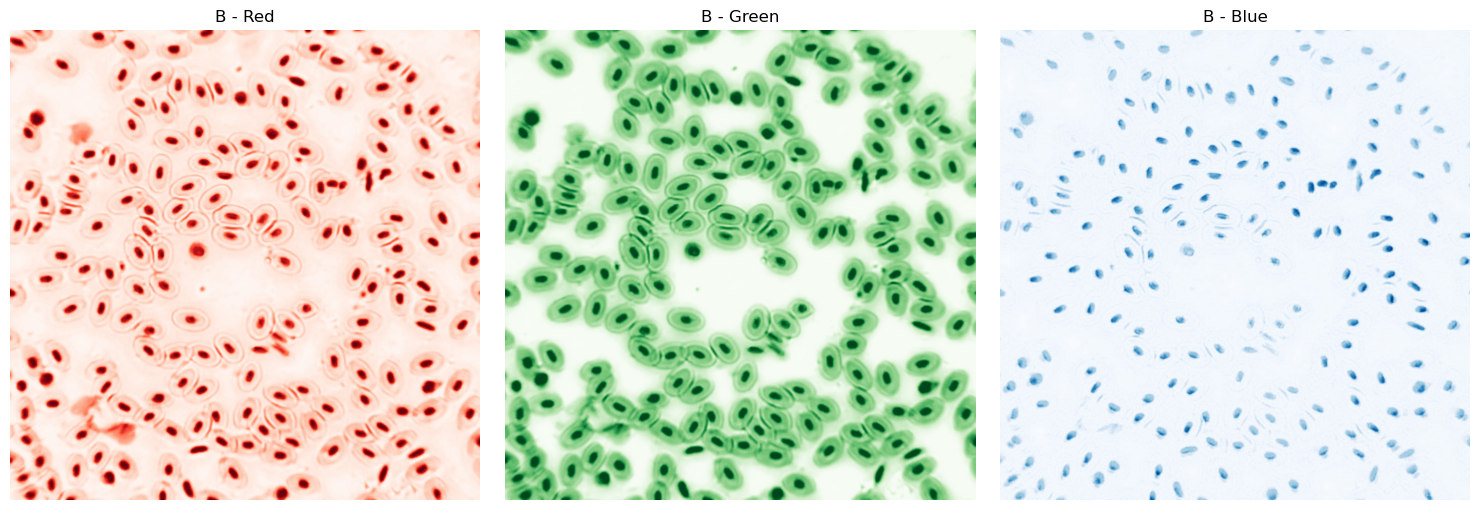

In [2]:
# Applica una convoluzione gaussiana (filtro) a ciascun canale dell'immagine B con sigma_B
sigma_B = 1

B_convolution = np.stack([ndi.gaussian_filter(B[:, :, ch], sigma_B) for ch in range(3)], axis=-1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
channels = ['Red', 'Green', 'Blue']
cmaps = ['Reds_r', 'Greens_r', 'Blues_r']

for j in range(3):
    axs[j].imshow(B_convolution[:, :, j], cmap=cmaps[j])
    axs[j].set_title(f'B - {channels[j]}')
    axs[j].axis('off')

plt.tight_layout()
plt.show()


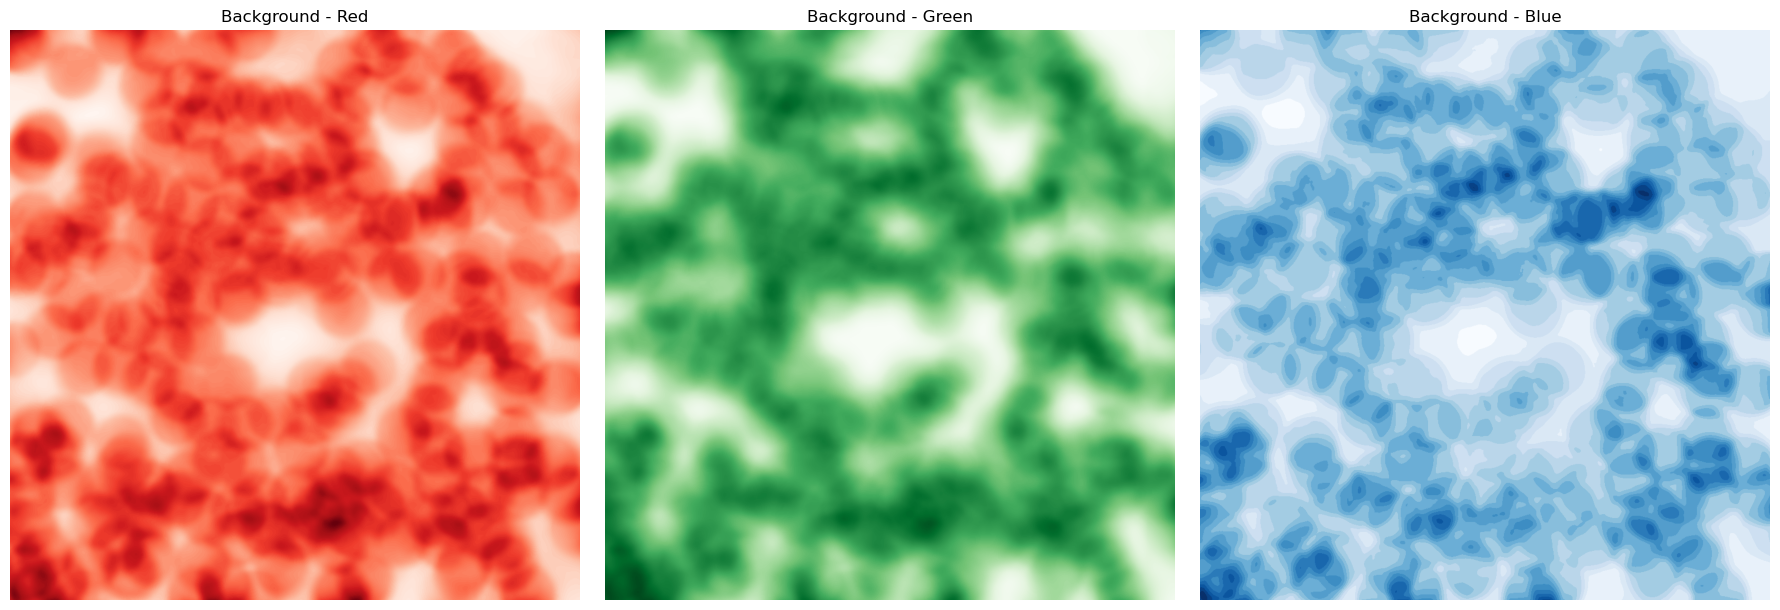

In [3]:
BKG_B_red = pd.read_csv('BKG_B_red.csv', header=None).to_numpy()
BKG_B_green = pd.read_csv('BKG_B_green.csv', header=None).to_numpy()
BKG_B_blue = pd.read_csv('BKG_B_blue.csv', header=None).to_numpy()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
backgrounds = [BKG_B_red, BKG_B_green, BKG_B_blue]

for i, (bkg, channel, cmap) in enumerate(zip(backgrounds, channels, cmaps)):
    axs[i].imshow(bkg, cmap=cmap)
    axs[i].set_title(f'Background - {channel}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

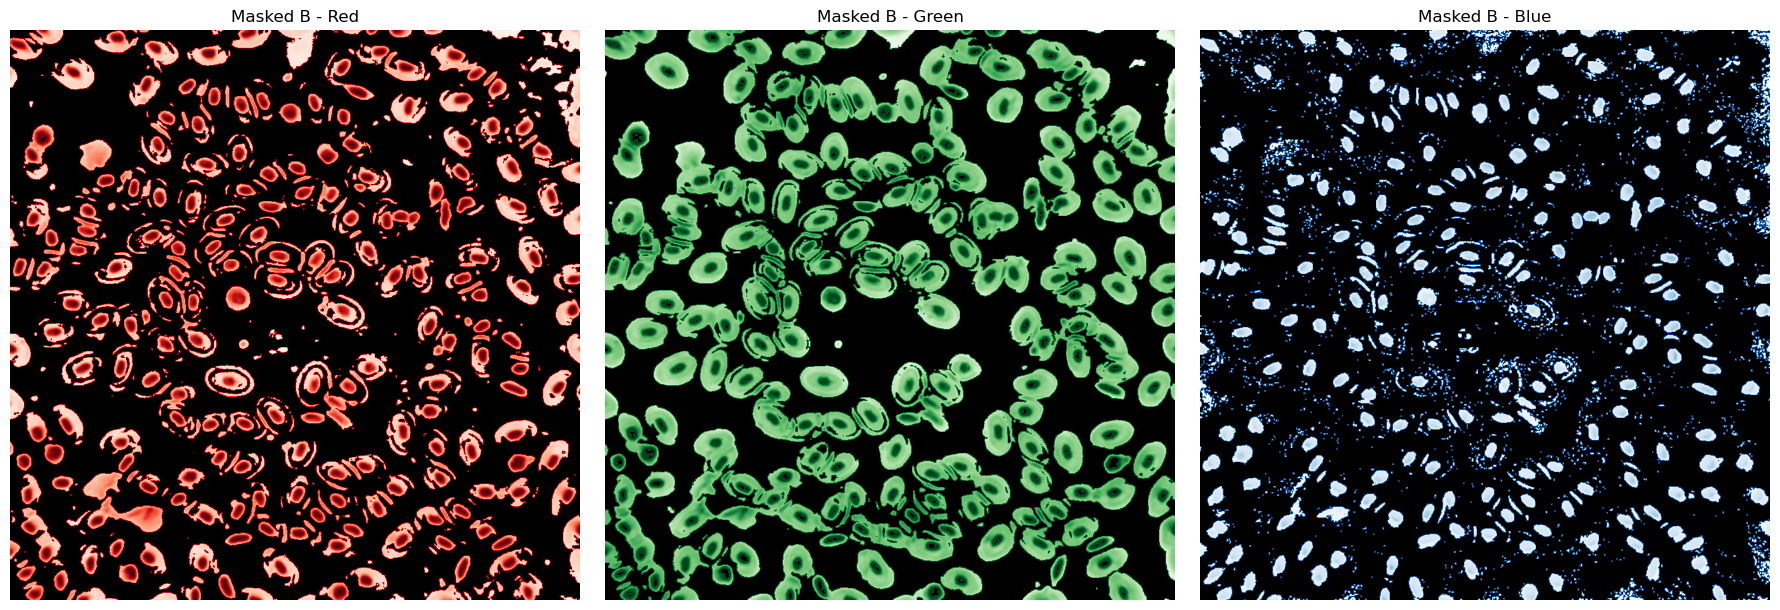

In [4]:
diff = B_convolution[:,:,0] < BKG_B_red
masked_B_red = np.where(diff, B_convolution[:,:,0], 0)

diff = B_convolution[:,:,1] < BKG_B_green
masked_B_green = np.where(diff, B_convolution[:,:,1], 0)

diff = B_convolution[:,:,2] < BKG_B_blue
masked_B_blue = np.where(diff, B_convolution[:,:,2], 0)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
masked_images = [masked_B_red, masked_B_green, masked_B_blue]
for i, (img, channel, cmap) in enumerate(zip(masked_images, channels, cmaps)):
    axs[i].imshow(img, cmap=cmap, vmin=0, vmax=img.max())
    axs[i].set_title(f'Masked B - {channel}')
    axs[i].axis('off')
    axs[i].imshow(np.ma.masked_where(img != 0, img), cmap='gray', vmin=0, vmax=1, alpha=1)  # overlay black for zeros
plt.tight_layout()
plt.show()

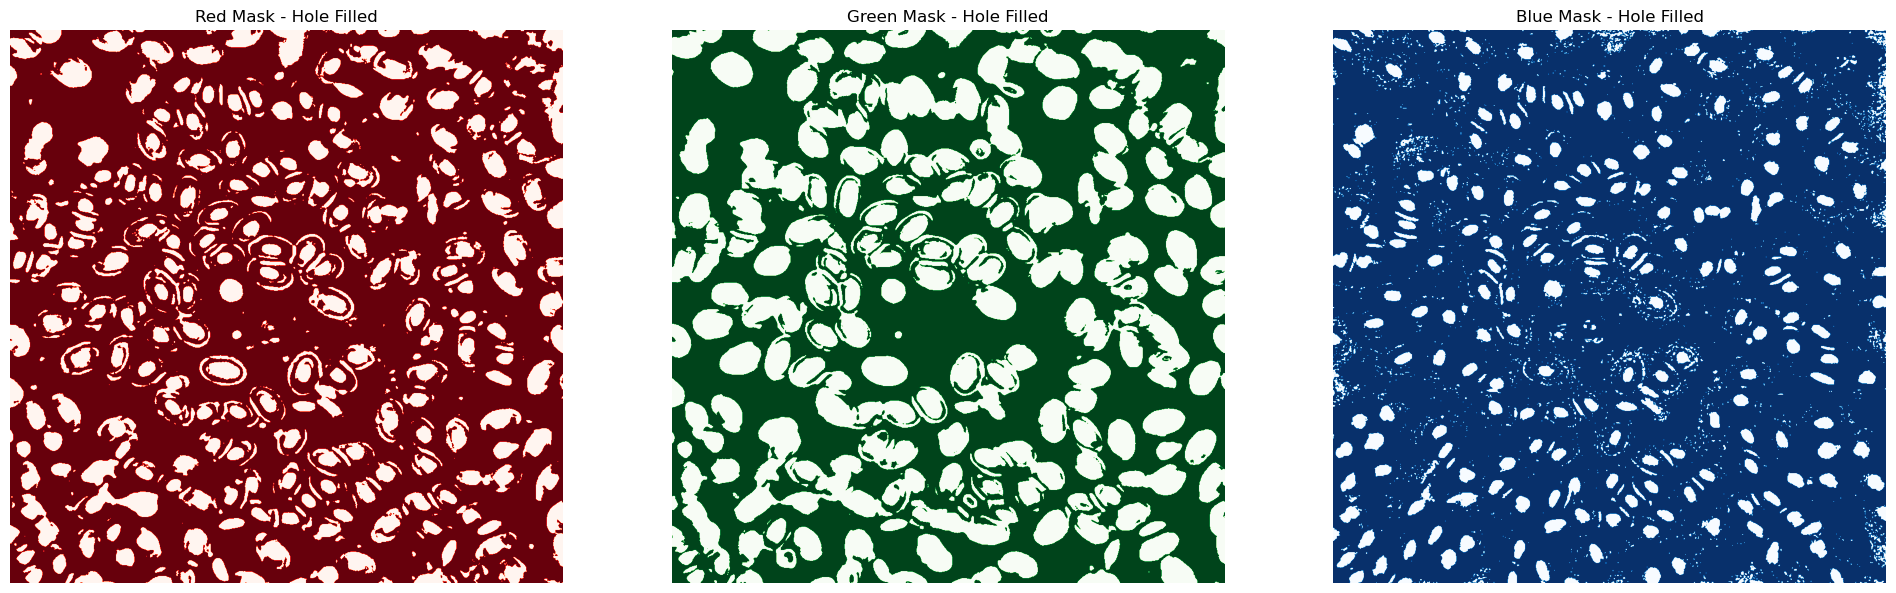

In [5]:
from scipy.ndimage import binary_fill_holes

B_red_filled = binary_fill_holes(masked_B_red, structure=np.ones((7, 7)))
B_green_filled = binary_fill_holes(masked_B_green, structure=np.ones((9, 9)))
B_blue_filled = binary_fill_holes(masked_B_blue, structure=np.ones((9, 9)))

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].imshow(B_red_filled, cmap='Reds_r')
axs[0].set_title('Red Mask - Hole Filled')
axs[0].axis('off')

axs[1].imshow(B_green_filled, cmap='Greens_r')
axs[1].set_title('Green Mask - Hole Filled')
axs[1].axis('off')

axs[2].imshow(B_blue_filled, cmap='Blues_r')
axs[2].set_title('Blue Mask - Hole Filled')
axs[2].axis('off')

plt.tight_layout()
plt.show()


butto di nuovo il rosso

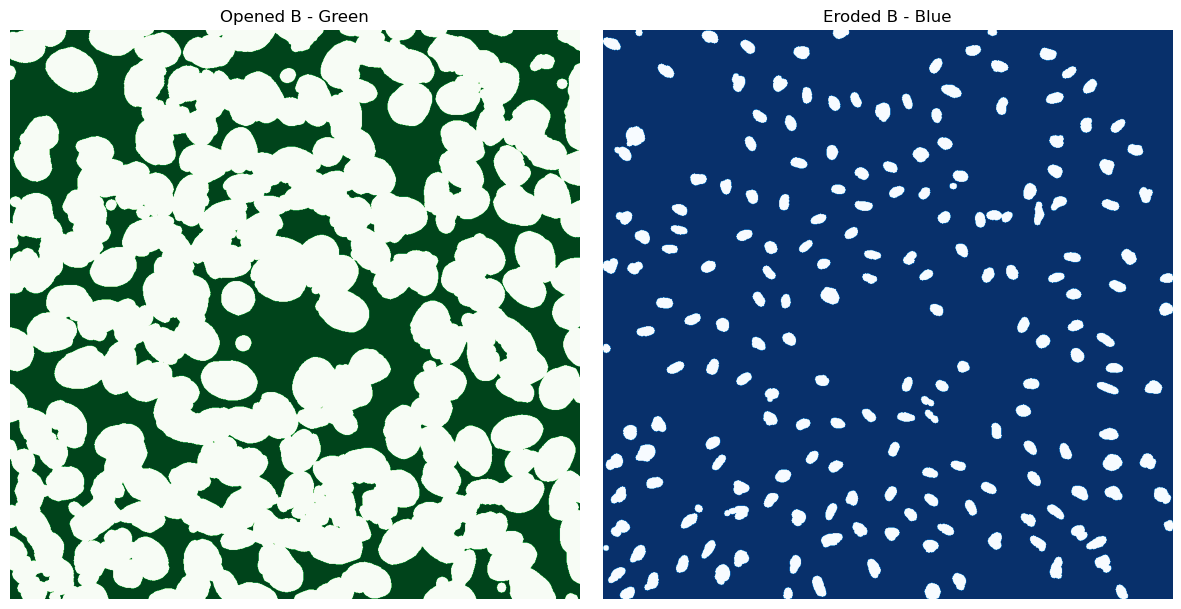

In [6]:
def circleSE(radius):
    """Create a circular structuring element with given radius."""
    L = np.arange(-radius, radius+1)
    X, Y = np.meshgrid(L, L)
    return (X**2 + Y**2) <= radius**2

# Opening on green channel
masked_B_green_binary = B_green_filled > 0
B_green_opened = ndi.binary_dilation(masked_B_green_binary, structure=circleSE(8))
B_green_eroded = ndi.binary_erosion(B_green_opened, structure=circleSE(4))

# Erosion then opening on blue channel
masked_B_blue_binary = B_blue_filled > 0
B_blue_eroded = ndi.binary_opening(masked_B_blue_binary, structure=circleSE(5))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(B_green_opened, cmap='Greens_r')
axs[0].set_title('Opened B - Green')
axs[0].axis('off')

axs[1].imshow(B_blue_eroded, cmap='Blues_r')
axs[1].set_title('Eroded B - Blue')
axs[1].axis('off')

plt.tight_layout()
plt.show()

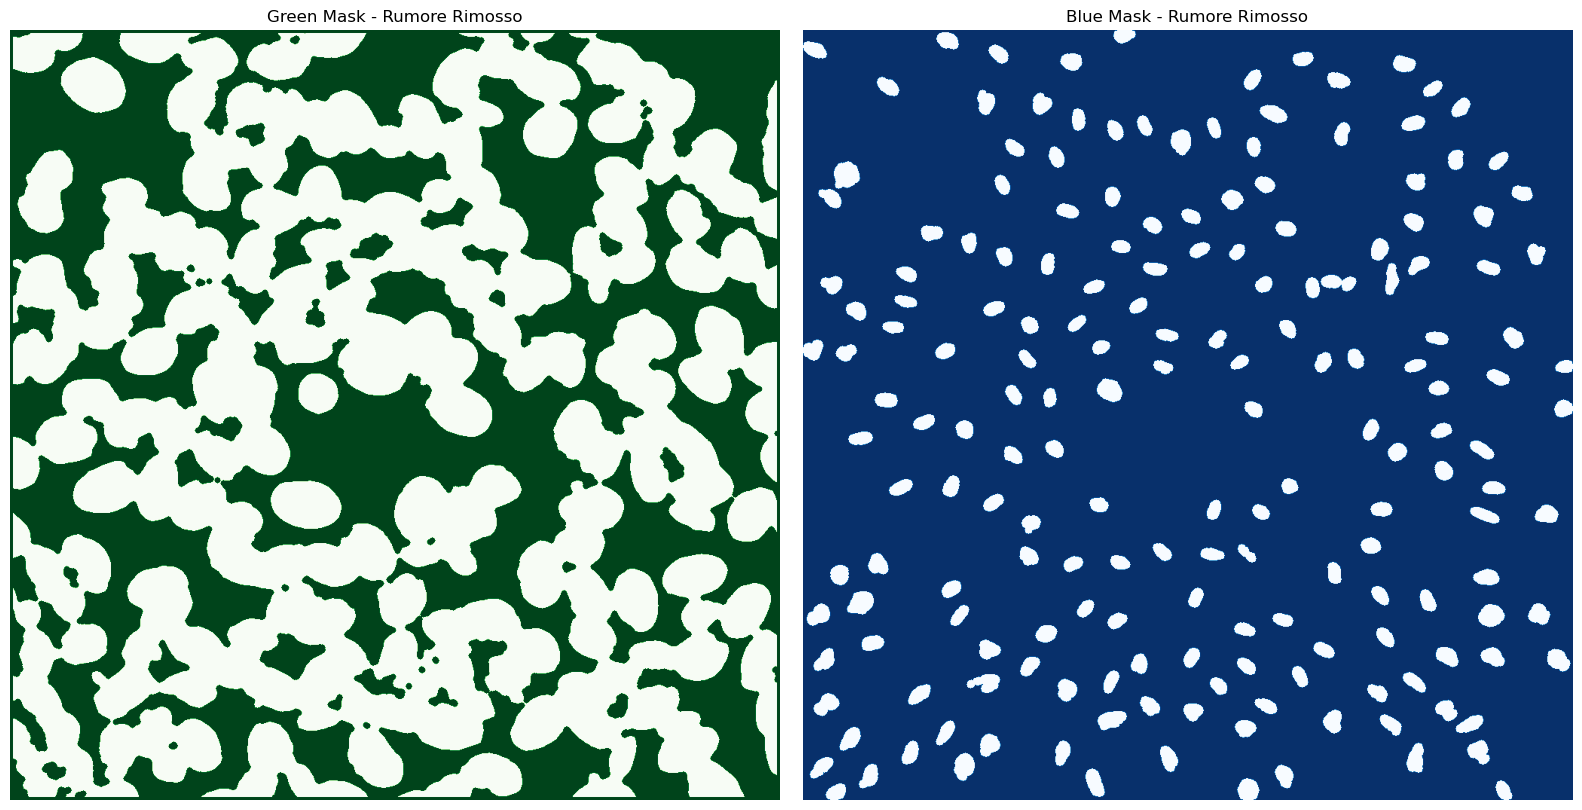

In [7]:
from skimage.morphology import remove_small_objects

min_size_g = 2000  # Dimensione minima per gli oggetti verdi
min_size_b = 300  # Dimensione minima per gli oggetti blu

# Rimuovi oggetti piccoli
B_green_cleaned = remove_small_objects(B_green_eroded, min_size=min_size_g)
B_blue_cleaned = remove_small_objects(B_blue_eroded, min_size=min_size_b)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(B_green_cleaned, cmap='Greens_r')
axs[0].set_title('Green Mask - Rumore Rimosso')
axs[0].axis('off')
axs[1].imshow(B_blue_cleaned, cmap='Blues_r')
axs[1].set_title('Blue Mask - Rumore Rimosso')
axs[1].axis('off')
plt.tight_layout()
plt.show()


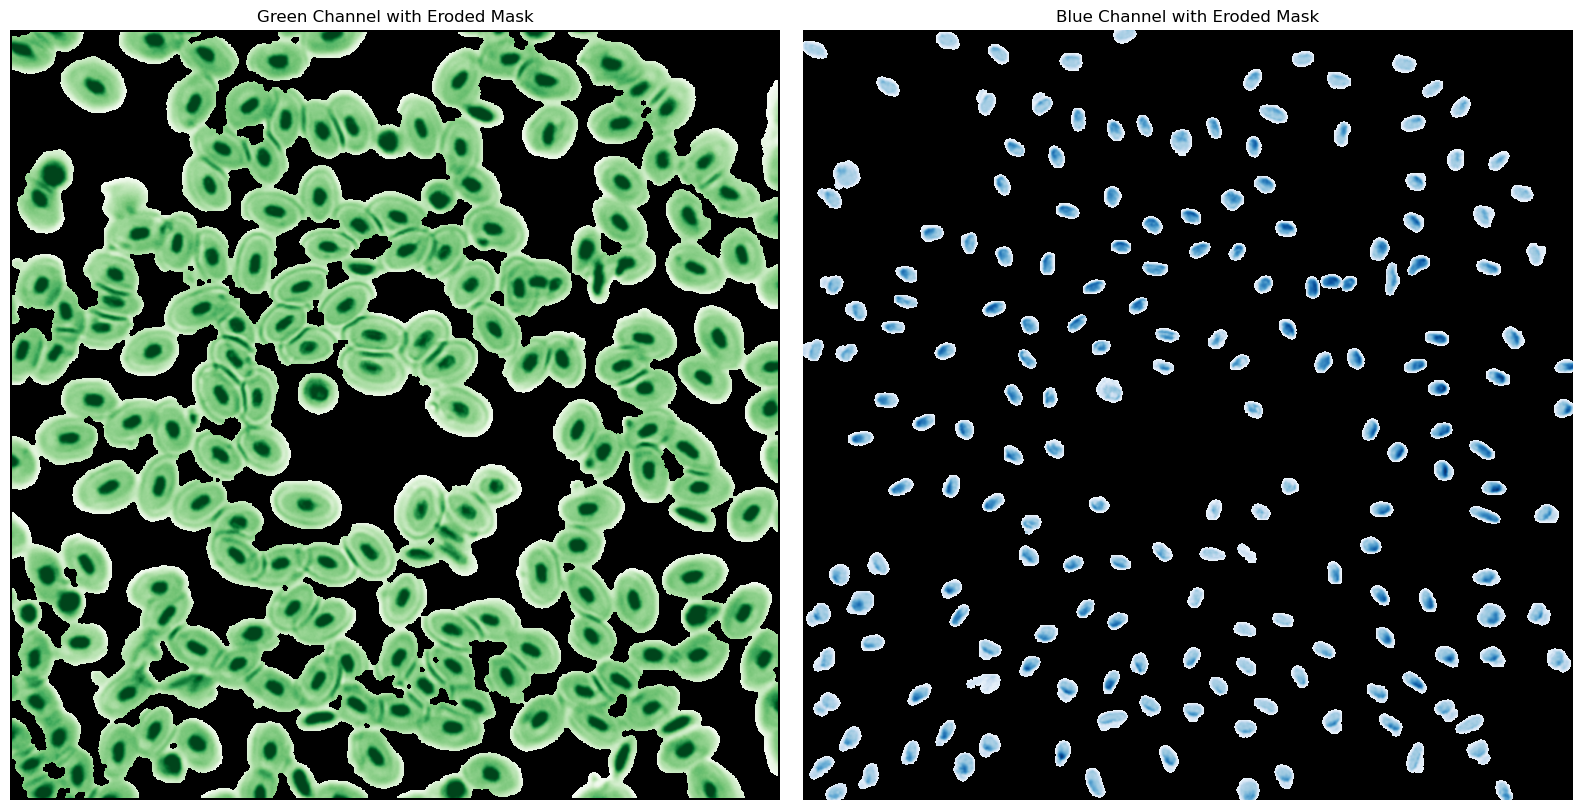

In [9]:

B_green_cleaned = np.where(B_green_cleaned, np.nan, 0)
B_blue_cleaned = np.where(B_blue_cleaned, np.nan, 0)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Overlay green mask on green channel
axs[0].imshow(B_convolution[:, :, 1], cmap='Greens_r')
axs[0].imshow(B_green_cleaned, cmap='gray', alpha=1)
axs[0].set_title('Green Channel with Eroded Mask')
axs[0].axis('off')

# Overlay blue mask on blue channel
axs[1].imshow(B_convolution[:, :, 2], cmap='Blues_r')
axs[1].imshow(B_blue_cleaned, cmap='gray', alpha=1)
axs[1].set_title('Blue Channel with Eroded Mask')
axs[1].axis('off')

plt.tight_layout()
plt.show()


Number of green objects: 14
Number of blue objects: 184


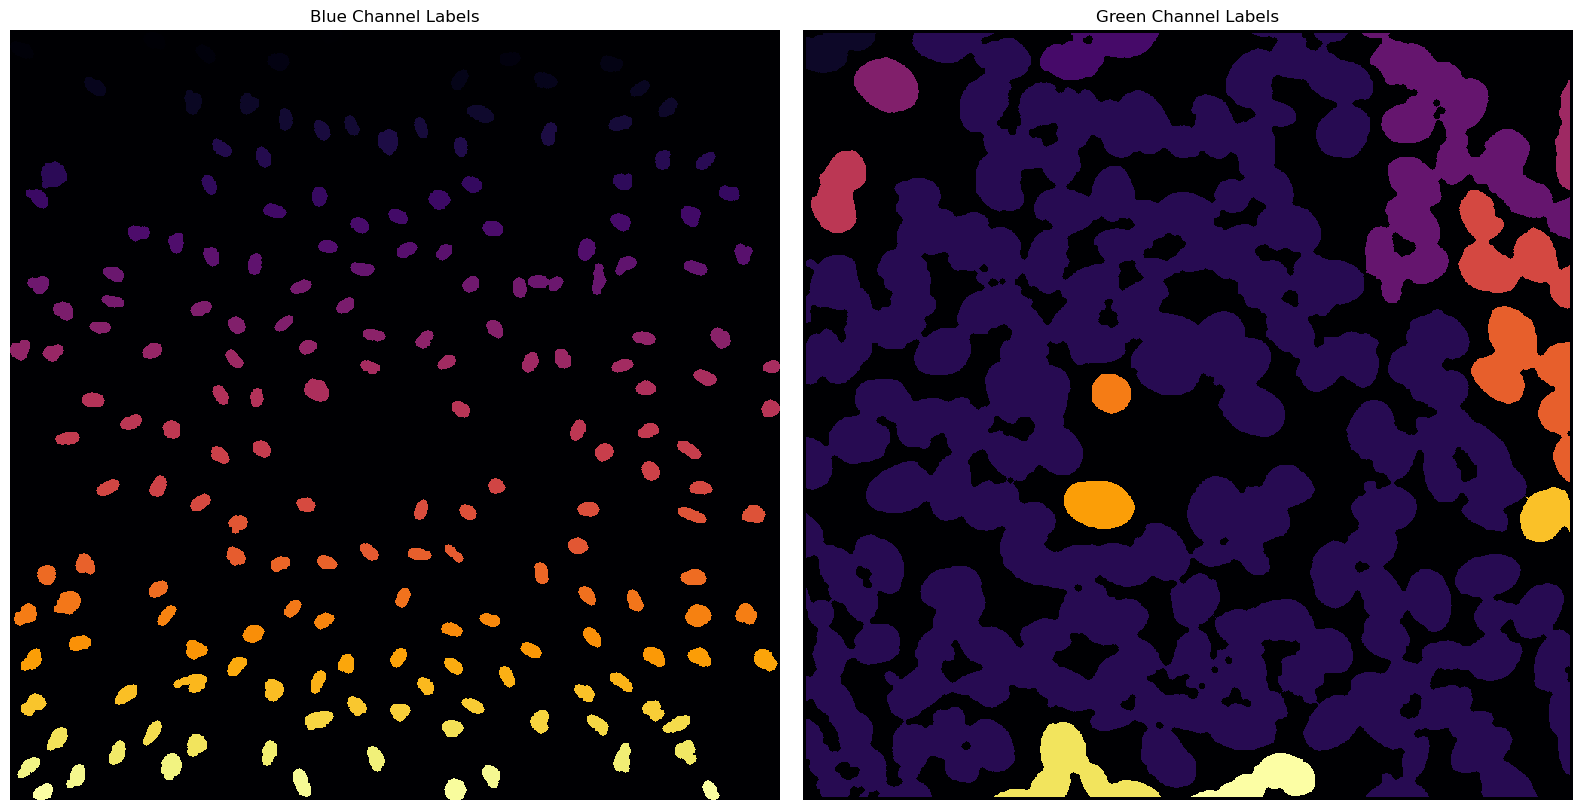

In [10]:
# Label connected components for green mask
green_labels, num_green = ndi.label(np.isnan(B_green_cleaned))
print(f'Number of green objects: {num_green}')
# Label connected components for blue mask
blue_labels, num_blue = ndi.label(np.isnan(B_blue_cleaned))
print(f'Number of blue objects: {num_blue}')

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Blue labels
axs[0].imshow(blue_labels, cmap='inferno', interpolation='none')
axs[0].set_title('Blue Channel Labels')
axs[0].axis('off')

# Green labels
axs[1].imshow(green_labels, cmap='inferno', interpolation='none', vmin=0)
axs[1].set_title('Green Channel Labels')
axs[1].axis('off')

plt.tight_layout()
plt.show()


ahi ahi ahi per ilverde dovremo watersheddare un sacco


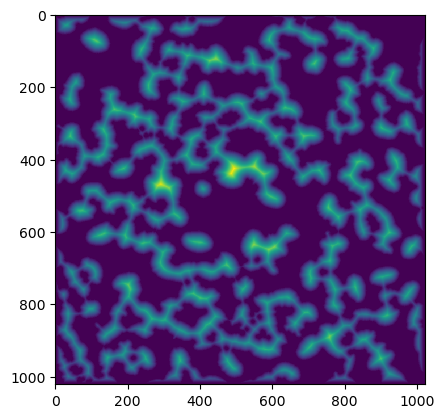

In [12]:
dist_trans = ndi.distance_transform_edt(B_green_cleaned)
plt.figure()
plt.imshow(dist_trans,interpolation='none',cmap='viridis')
plt.show()

/tmp/ipykernel_16926/2289453865.py:6: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  dist_trans_dil = ndi.filters.maximum_filter(dist_trans, footprint=struct)


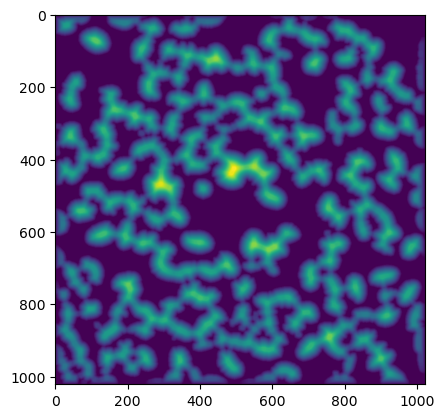

In [38]:
i = 10
mgrid = np.mgrid[:i,:i]
struct = (mgrid[0] - np.floor(i/2))**2 + (mgrid[1] - np.floor(i/2))**2 <= np.floor(i/2)**2

# Running the dilation
dist_trans_dil = ndi.filters.maximum_filter(dist_trans, footprint=struct) 

# Visualizing again
plt.figure()
plt.imshow(dist_trans_dil, cmap='viridis')
plt.show()

tripofobia portami via

In [41]:
from skimage.feature import peak_local_max

seedLoc = peak_local_max(dist_trans_dil, min_distance=15)
seeds = np.zeros_like(dist_trans_dil, dtype=bool)
seeds[tuple(seedLoc.T)] = True

print(f'Number of seeds: {len(seedLoc)}')



Number of seeds: 197


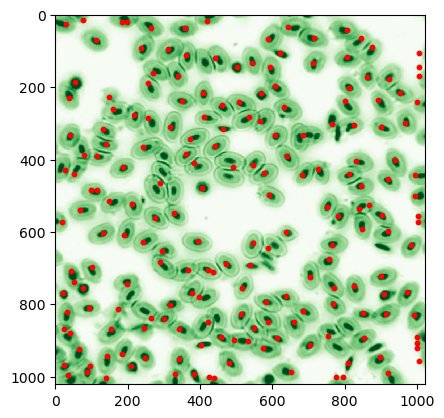

In [42]:
plt.figure()
plt.imshow(B_convolution[:, :, 1], cmap='Greens_r', interpolation='none')

y, x = np.where(seeds)
plt.scatter(x, y, c='red', s=10, marker='o')
plt.show()

seeds_labeled = ndi.label(seeds)[0]